# SYSNet: Systematics Treatment with Neural Networks

`SYSNet` was developed to tackle the problem of imaging systematic effects, e.g., Galactic dust, in galaxy survey data.

## Installation
We recommend Conda for installing the required packages:
```bash
  conda create -q -n sysnet python=3.8 scikit-learn git jupyter ipykernel ipython mpi4py matplotlib
  conda activate sysnet
  conda install pytorch torchvision -c pytorch
  conda install -c conda-forge fitsio healpy absl-py pytables pyyaml
```
Then, clone the sysnetdev repository using `git clone https://github.com/mehdirezaie/sysnetdev.git` and add the path to the PYTHONPATH variable:

`export PYTHONPATH=\path\to\sysnetdev:$PYTHONPATH`, you need to replace `\path\to\sysnetdev` with the path to sysnetdev in your system. Finally execute the following command in the terminal to add the sysnet kernel to your Jupyter notebook:
```bash
  python -m ipykernel install --user --name=sysnet --display-name "python (sysnet)"
```

## Summary

#### Preprocessing
The input data to `SYSNet` is a tabulated data of the following fields:
1. `hpix`: (int) HEALPix index
2. `label`: (float) number count of galaxies (or quasars) in pixel
3. `fracgood`: (float) weight associated to pixel (the network output will be multiplied by this factor)
4. `features`: (float) array holding imaging properties for pixel

#### Neural Network regression
The `SYSNet` software is called in this step to perform a regression analysis modeling the relationship between `label` and `features`.

#### Postprocessing
The `SYSNet` output will be used to assign appropriate _weights_ to galaxies to account for observational systematics.

## Demo
In the following, we aim to provide a demo of the regression and postprocessing steps.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys 
import numpy as np
import healpy as hp
import fitsio as ft
sys.path.append('/home/mehdi/github/sysnetdev') # 'Cause SYSNet is not installed yet
from sysnet import SYSNet, Config, TrainedModel
%matplotlib inline

('label', '>f8')
('hpix', '>i8')
('features', '>f8', (18,))
('fracgood', '>f8')


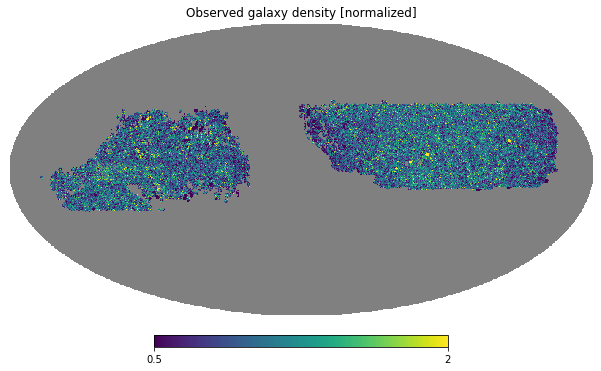

In [3]:
### Input data
input_ = ft.read('../input/eBOSS.ELG.NGC.DR7.table.fits')  # read tab. data

for array in input_.dtype.descr:
    print(array)
     
# for visualization    
nside = 256
ng = np.zeros(12*nside*nside)
ng[:] = np.nan
ng[input_['hpix']] = input_['label']    

# Mollweide projection
hp.mollview(ng, rot=-85, min=0.5, max=2.0,
            title='Observed galaxy density [normalized]')

In [4]:
config = Config('../scripts/config.yaml')   # read config file
config.__dict__

{'input_path': '../input/eBOSS.ELG.NGC.DR7.table.fits',
 'output_path': '../output/model_test',
 'restore_model': None,
 'batch_size': 512,
 'nepochs': 2,
 'nchains': 1,
 'find_lr': False,
 'find_structure': False,
 'find_l1': False,
 'do_kfold': False,
 'do_tar': False,
 'snapshot_ensemble': False,
 'normalization': 'z-score',
 'model': 'dnn',
 'optim': 'adamw',
 'scheduler': 'cosann',
 'axes': [0, 1, 2],
 'do_rfe': False,
 'eta_min': 1e-05,
 'learning_rate': 0.001,
 'nn_structure': [4, 20],
 'l1_alpha': -1.0,
 'loss': 'mse'}

In [5]:
# let's update some input arguments
config.update('nepochs', 30)
config.update('axes', [i for i in range(18)]) # num of features for this dataset
config.update('batch_size', 4096)

# run learning rate finder
config.update('find_lr', True)
pipeline = SYSNet(config) # perform regression
pipeline.run()

logging in ../output/model_test/train.log
# --- inputs params ---
input_path: ../input/eBOSS.ELG.NGC.DR7.table.fits
output_path: ../output/model_test
restore_model: None
batch_size: 4096
nepochs: 30
nchains: 1
find_lr: True
find_structure: False
find_l1: False
do_kfold: False
do_tar: False
snapshot_ensemble: False
normalization: z-score
model: dnn
optim: adamw
scheduler: cosann
axes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
do_rfe: False
eta_min: 1e-05
learning_rate: 0.001
nn_structure: [4, 20]
l1_alpha: -1.0
loss: mse
loss_kwargs: {'reduction': 'sum'}
optim_kwargs: {'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.0, 'amsgrad': False}
scheduler_kwargs: {'eta_min': 1e-05, 'T_0': 10, 'T_mult': 2}
device: cpu
pipeline initialized in 0.039 s
data loaded in 0.226 sec
# running pipeline ...
# training and evaluation
partition_0 with (4, 20, 18, 1)


# of data:,  187257


# running hyper-parameter tunning ...
# running learning rate finder ... 


Learning rate search finished. See the graph with {finder_name}.plot()


SystemExit: LR finder done in 35.296 sec, check out ../output/model_test/loss_vs_lr_0.png

/home/mehdi/miniconda3/envs/sysnet/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


![this image](../output/model_test/loss_vs_lr_0.png)

logging in ../output/model_test/train.log
# --- inputs params ---
input_path: ../input/eBOSS.ELG.NGC.DR7.table.fits
output_path: ../output/model_test
restore_model: None
batch_size: 4096
nepochs: 30
nchains: 1
find_lr: False
find_structure: False
find_l1: False
do_kfold: False
do_tar: False
snapshot_ensemble: False
normalization: z-score
model: dnn
optim: adamw
scheduler: cosann
axes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
do_rfe: False
eta_min: 1e-05
learning_rate: 0.02
nn_structure: [4, 20]
l1_alpha: -1.0
loss: mse
loss_kwargs: {'reduction': 'sum'}
optim_kwargs: {'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.0, 'amsgrad': False}
scheduler_kwargs: {'eta_min': 1e-05, 'T_0': 10, 'T_mult': 2}
device: cpu
pipeline initialized in 0.023 s
data loaded in 0.169 sec
# running pipeline ...
# training and evaluation
partition_0 with (4, 20, 18, 1)


# of data:,  187257


base_train_loss: 0.139704
base_valid_loss: 0.142347
base_test_loss: 0.144221
# running training and evaluation with seed: 2664485226
Epoch 0/29 train loss: 0.394850 valid loss: 0.146402 lr: 0.019545
Epoch 1/29 train loss: 0.143398 valid loss: 0.139065 lr: 0.018157
Epoch 2/29 train loss: 0.135036 valid loss: 0.137589 lr: 0.015970
Epoch 3/29 train loss: 0.133679 valid loss: 0.136688 lr: 0.013200
Epoch 4/29 train loss: 0.132937 valid loss: 0.136002 lr: 0.010117
Epoch 5/29 train loss: 0.132384 valid loss: 0.135414 lr: 0.007023
Epoch 6/29 train loss: 0.131956 valid loss: 0.135089 lr: 0.004221
Epoch 7/29 train loss: 0.131641 valid loss: 0.134955 lr: 0.001985
Epoch 8/29 train loss: 0.131434 valid loss: 0.134864 lr: 0.000534
Epoch 9/29 train loss: 0.131318 valid loss: 0.134837 lr: 0.000011
Epoch 10/29 train loss: 0.131906 valid loss: 0.135406 lr: 0.019886
Epoch 11/29 train loss: 0.131740 valid loss: 0.135140 lr: 0.019528
Epoch 12/29 train loss: 0.131189 valid loss: 0.134488 lr: 0.018936
Epoch 

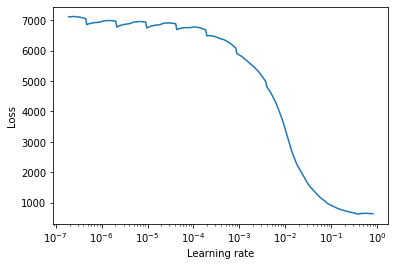

In [6]:
# let's re-train the network with the best learning rate
# monitor validation loss

config.update('find_lr', False) # remember to turn this off
config.update('learning_rate', 0.02)
pipeline = SYSNet(config) # perform regression
pipeline.run()

The code outputs several files:
1. `nn-weights.fits`: this file has healpix index and predicted galaxy count
2. `metrics.npz`: training, validation, test loss
3. `best.pth.tar`: the best model parameters

In [9]:
import matplotlib.pyplot as plt
import os
import sys
import logging

import numpy as np
import fitsio as ft
from time import time
from glob import glob

import torch
import sysnet.sources as src

In [17]:
class TrainedModel:
    
    def __init__(self, model, checkpoint, pid, nnstruct=(4, 20), num_features=17):
        
        self.DNNx = src.init_model(model)
        self.dnnx = self.DNNx(*nnstruct, input_dim=num_features)
        checkpoint = src.load_checkpoint(checkpoint, self.dnnx)
        self.stats =  checkpoint['stats']
        
    def forward(self, indata):
        dl = src.load_data(indata, self.stats)
        
        result = src.forward(self.dnnx, dl, {'device':'cpu'})
        hpix = result[0].numpy()            
        nnw = result[1].numpy().flatten()
        #return Table([hpix, nnw], names=['hpix', 'weight'])
        return (hpix, nnw)

In [19]:
tm = TrainedModel('dnn', # name of the model
                  '../output/model_test/model_0_2664485226/best.pth.tar', # best model part 0 seed 2664485226
                  0, # partition of the model
                  (4, 20), # structure of the network
                  18) # num of input features

In [20]:
hpix, npred = tm.forward('../input/eBOSS.ELG.NGC.DR7.table.fits') 
npred = npred / npred.mean()  # normalize
npred = npred.clip(0.5, 2.0)  # avoid extreme predictions


ng_ = np.zeros(12*256*256)
ng_[:] = np.nan
ng_[hpix] = npred

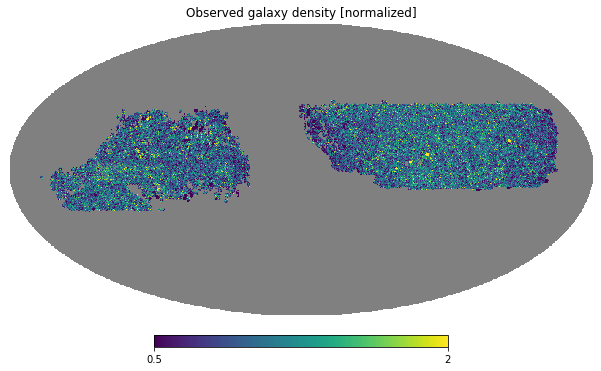

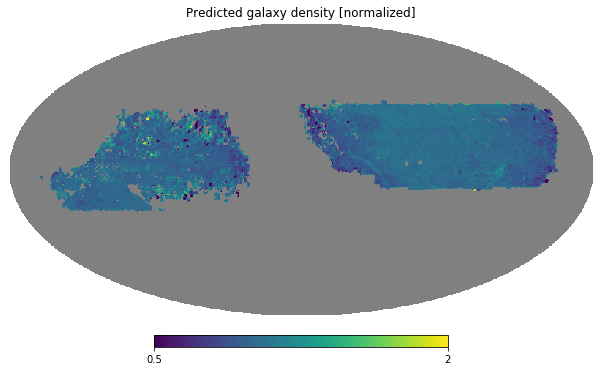

In [22]:
hp.mollview(ng, rot=-85, min=0.5, max=2.0,
            title='Observed galaxy density [normalized]')

hp.mollview(ng_, rot=-85, min=0.5, max=2.0,
            title='Predicted galaxy density [normalized]')

For 30 training epochs, a single fold, and a single chain model, this is not a bad result. In practice, we use 5-fold validation (`do_kfold=True`) and train 20 chains (`nchains=20`) for 70-300 epochs.

If you have any questions, feel free to email me at mr095415@ohio.edu.

In [23]:
d = np.load('../output/model_test/metrics.npz', allow_pickle=True)

In [25]:
d.files

['base_losses', 'losses']

In [26]:
d['base_losses']

array([{'base_train_loss': 0.1397041231393814, 'base_valid_loss': 0.14234690368175507, 'base_test_loss': 0.14422108232975006}],
      dtype=object)